In [1]:
from data_pipeline import Pipeline

In [2]:
import os
import json
import cv2
from PIL import Image
import pytesseract
import numpy as np
import matplotlib.pyplot as plt

In [18]:
all_annotations = {
    "info": {},
    "licenses": [],
    "images": [],
    "annotations": [],
    "categories": []
}

for subentry in os.listdir('images/'):
    if subentry.endswith('.xml'):
        coco_annotation = Pipeline.convert_pascal_to_coco_format('images/' + subentry)
        coco_annotation["annotations"][0]['id'] = subentry.split('.')[0] 
        all_annotations["images"].extend(coco_annotation["images"])
        all_annotations["annotations"].extend(coco_annotation["annotations"])
        if not all_annotations["info"]:
            all_annotations["info"] = coco_annotation["info"]
        if not all_annotations["licenses"]:
            all_annotations["licenses"] = coco_annotation["licenses"]
        if not all_annotations["categories"]:
            all_annotations["categories"] = coco_annotation["categories"]

with open("combined_coco_annotations.json", "w") as f:
    json.dump(all_annotations, f, indent=4)

In [138]:
all_yolo_annotations = []

for subentry in os.listdir('images/'):
    if subentry.endswith('.xml'):
        yolo_annotation = Pipeline.convert_pascal_to_yolo_format('images/' + subentry)
        image_name = subentry.split(".")[0]
        all_yolo_annotations.extend([f"{image_name}, {ann}" for ann in yolo_annotation])

with open("combined_yolo_annotations.txt", "w") as f:
    for ann in all_yolo_annotations:
        f.write(ann + '\n')

# Part 2

In [128]:
def extract_license_plate_text(cropped_image):
    
    gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    _, thresh_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((1, 1), np.uint8)
    img_dilated = cv2.dilate(thresh_image, kernel, iterations=1)
    text = pytesseract.image_to_string(img_dilated, config ='--oem 1 -l eng --psm 8')
    
    return text.strip()

In [163]:
def crop_license_plate(image_path, format_type="coco"):
    image = cv2.imread(image_path)
    image_name = image_path.split('/')[1]
    img_width = image.shape[1]
    img_height = image.shape[0]
    
    if format_type == "coco":

        with open('combined_coco_annotations.json', 'r') as j:
            data = json.loads(j.read())

        image_id = None
        for image_data in data["images"]:
            print(image_name, image_data["file_name"])
            if image_data["file_name"] == image_name:
                print(image_data["id"])
                image_id = image_data["id"]
                break
        # Ensure the image ID was found before proceeding
        if image_id is not None:
            print(image_id)
            # Extract bounding box information for the specified image
            bboxes = []
            for annotation in data["annotations"]:
                if annotation["image_id"] == image_id:
                    x_min, y_min, width, height = annotation["bbox"]
                    return image[y_min:y_min+height, x_min:x_min+width]


        
        
    elif format_type == "yolo":
        with open('combined_yolo_annotations.txt', 'r') as j:
            contents = j.readlines()
        for line in contents:
            if(line.split(',')[0] == image_name.split('.')[0]):
                contents = line.split(', ')
        contents.pop(0)
        contents.pop(0)
        contents[3]= contents[3].split("\n")[0]
        x_center, y_center, width, height = map(float, contents)
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height
        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        return image[y_min:y_min+int(height), x_min:x_min+int(width)]
        
    


In [164]:
def get_license_plate(image_path, format_type="coco"):
    image = cv2.imread(image_path)
    imgplot = plt.imshow(image)
    plt.show()
    cropped = crop_license_plate(image_path, format_type)
    imgplot = plt.imshow(cropped)
    plt.show()
    print("License Plate Number:", extract_license_plate_text(cropped))

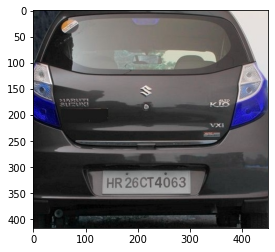

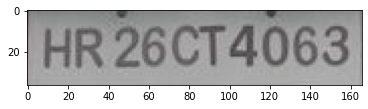

License Plate Number: ‘HR 26CT4063


In [165]:
get_license_plate('images/N100.jpeg', "yolo")